In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# 准备数据



In [ ]:
!pip install "labelbox[data]"

     |████████████████████████████████| 162 kB 4.9 MB/s 
     |████████████████████████████████| 10.9 MB 49.6 MB/s 
     |████████████████████████████████| 6.3 MB 37.8 MB/s 
  Created wheel for pygeotile: filename=pyGeoTile-1.0.6-py3-none-any.whl size=4890 sha256=11413a917f65ffa846dec78d604bbb532d1e4cd28cce8a0329a9ffd1c4c34476
  Stored in directory: /root/.cache/pip/wheels/8e/5a/69/a618c26d126c38b48937127f422564922ea10c9d00680f9943
Successfully built pygeotile


In [ ]:
from labelbox import Client, OntologyBuilder
from labelbox.data.annotation_types import Geometry
from  labelbox.data.annotation_types.collection import LabelList
from PIL import Image
import numpy as np
import os
import torch

In [ ]:
from enum import Enum

class SegClsName:
  VESSEL = "血管"
  BRONCHUS = "支气管"

  def get_all_names():
    return ['支气管', '血管']

In [ ]:
API_KEY = "YOURS"
PROJECT_ID = "YOURS"
client = Client(api_key=API_KEY)
project = client.get_project(PROJECT_ID)
labels = project.label_generator().as_list()

/usr/local/lib/python3.7/dist-packages/labelbox/data/annotation_types/classification/classification.py:85: UserWarning: Dropdown classification is deprecated and will be removed in a future release
  warnings.warn("Dropdown classification is deprecated and will be "


In [ ]:
def segmentation_cls_filter(lb_labels: LabelList, cls_name):
  '''取存在特定实体标签的样本'''
  result = LabelList()
  for lb in lb_labels:
    for a in lb.annotations:
      # print(a.name)
      if a.name == cls_name:
        result.append(lb)
        break

  return result

def classification_filter(lb_labels: LabelList):
  '''取存在全局分类标签的样本'''
  return LabelList([lb for lb in lb_labels if len(lb.classification_annotations())==0])

In [ ]:
class LabelBoxInstSegDataset(torch.utils.data.Dataset):

  def __init__(self, lb_labels, cls_name, transforms=None):
    self.transforms = transforms
    
    assert cls_name in SegClsName.get_all_names()
    self.cls_name = cls_name
    self.lb_labels = segmentation_cls_filter(lb_labels, cls_name)

  def __getitem__(self, idx):
    data_item = self.lb_labels[idx]
    # load images
    img = Image.fromarray(np.uint8(self.lb_labels[idx].data.value)).convert("RGB")
    mask = np.zeros((img.size[1], img.size[0]))
    for i, a in enumerate(data_item.annotations):
      if a.name == self.cls_name:
        mask += a.value.draw()[:, :, 0]

    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]

    # split the color-encoded mask into a set
    # of binary masks
    masks = (mask == obj_ids[:, None, None])

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      pos = np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      if xmin == xmax or ymin == ymax: continue
      boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.lb_labels)

In [ ]:
dataset = LabelBoxInstSegDataset(labels, SegClsName.BRONCHUS)
dataset[0]

(<PIL.Image.Image image mode=RGB size=1440x1024 at 0x7F8B80586410>,
 {'area': tensor([95760.]),
  'boxes': tensor([[691., 130., 995., 445.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

# 定义模型

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_detection_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # # now get the number of input features for the mask classifier
    # in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    # hidden_layer = 256
    # # and replace the mask predictor with a new one
    # model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 121496, done.
remote: Counting objects: 100% (14158/14158), done.
remote: Compressing objects: 100% (1167/1167), done.
remote: Total 121496 (delta 13048), reused 13920 (delta 12923), pack-reused 107338
Receiving objects: 100% (121496/121496), 235.13 MiB | 22.30 MiB/s, done.
Resolving deltas: 100% (105720/105720), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = LabelBoxInstSegDataset(labels, SegClsName.BRONCHUS, transforms=get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# 训练

In [ ]:
# use our dataset and defined transformations
dataset = LabelBoxInstSegDataset(labels, SegClsName.BRONCHUS, transforms=get_transform(train=True))
dataset_test = LabelBoxInstSegDataset(labels, SegClsName.BRONCHUS, transforms=get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-5])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-5:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10
train_seg_fromscratch = True

if train_seg_fromscratch:
  for epoch in range(num_epochs):
      # train for one epoch, printing every 10 iterations
      train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
      # update the learning rate
      lr_scheduler.step()
      # evaluate on the test dataset
      evaluate(model, data_loader_test, device=device)

  torch.save(model.state_dict(), "/content/drive/MyDrive/model.pt")
else:
  model.load_state_dict(torch.load("/content/drive/MyDrive/model.pt"))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/36]  eta: 0:02:48  lr: 0.000148  loss: 0.9676 (0.9676)  loss_classifier: 0.8182 (0.8182)  loss_box_reg: 0.1139 (0.1139)  loss_objectness: 0.0233 (0.0233)  loss_rpn_box_reg: 0.0122 (0.0122)  time: 4.6923  data: 2.5376  max mem: 2255
Epoch: [0]  [10/36]  eta: 0:00:55  lr: 0.001575  loss: 0.4225 (0.4839)  loss_classifier: 0.2556 (0.3641)  loss_box_reg: 0.0831 (0.0877)  loss_objectness: 0.0233 (0.0260)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 2.1298  data: 0.2510  max mem: 2521
Epoch: [0]  [20/36]  eta: 0:00:31  lr: 0.003002  loss: 0.3253 (0.4089)  loss_classifier: 0.1724 (0.2771)  loss_box_reg: 0.0889 (0.0953)  loss_objectness: 0.0282 (0.0300)  loss_rpn_box_reg: 0.0040 (0.0066)  time: 1.8639  data: 0.0207  max mem: 2521
Epoch: [0]  [30/36]  eta: 0:00:11  lr: 0.004429  loss: 0.2469 (0.3485)  loss_classifier: 0.1030 (0.2133)  loss_box_reg: 0.1055 (0.0989)  loss_objectness: 0.0156 (0.0292)  loss_rpn_box_reg: 0.0053 (0.0072)  time: 1.8561  data: 0.0184  max mem: 2521
Epoch: [

In [ ]:
device

device(type='cuda')

# 评估

In [ ]:
# pick one image from the test set
img, _ = dataset_test[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction

[{'boxes': tensor([[3.8019e+02, 4.2263e+02, 8.1876e+02, 7.6386e+02],
          [2.1563e+02, 2.1059e+02, 9.3482e+02, 8.1148e+02],
          [3.8363e+02, 4.4955e+02, 6.9207e+02, 6.6881e+02],
          [3.2684e+02, 9.0955e+01, 1.4196e+03, 6.9143e+02],
          [2.1469e+00, 1.6020e+01, 1.0872e+03, 8.4044e+02],
          [2.3890e+02, 3.5702e+02, 1.2154e+03, 8.8934e+02],
          [6.0275e+02, 2.3708e+02, 8.7061e+02, 4.2226e+02],
          [1.0604e+02, 1.1063e+01, 7.2587e+02, 6.7383e+02],
          [3.9146e+02, 2.2252e+02, 8.9363e+02, 6.4222e+02],
          [0.0000e+00, 4.1293e+02, 8.0450e+02, 1.0167e+03],
          [1.6899e+02, 1.1042e+00, 1.4232e+03, 3.9015e+02],
          [4.8890e+02, 1.8224e+02, 1.1038e+03, 9.3959e+02],
          [5.0766e+02, 2.1203e+02, 9.7080e+02, 4.5153e+02]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.7301, 0.3933, 0.2910, 0.2084, 0.2081, 0.1937, 0.1793, 0.1611, 0.1385,
          0.1161, 0.10

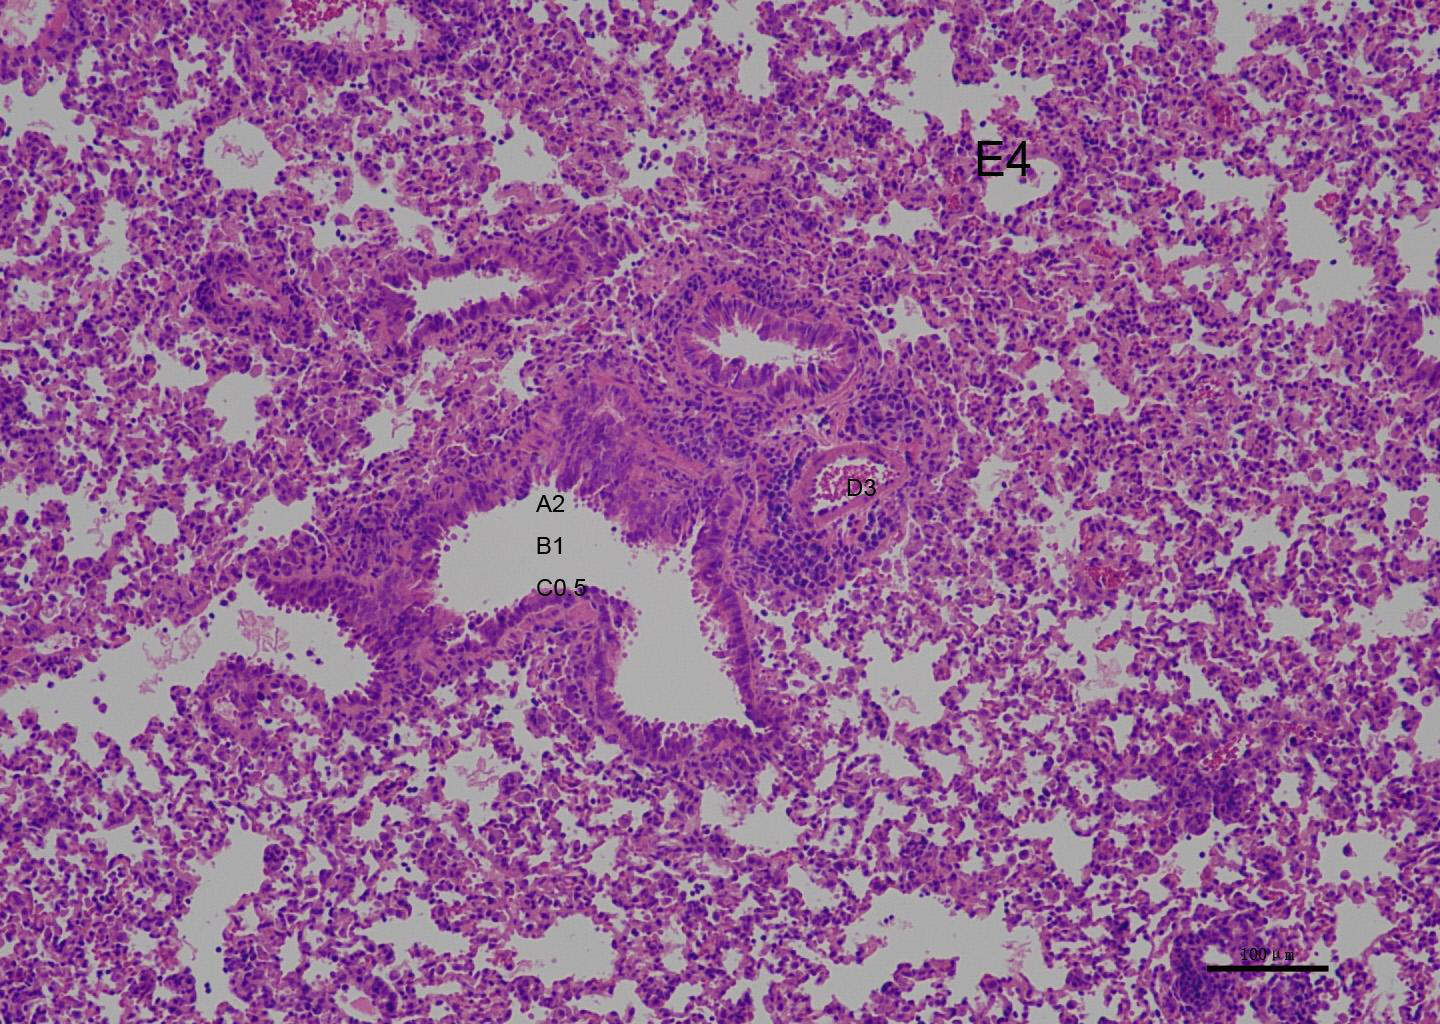

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
Image.fromarray(prediction[0]['masks'][16, 0].mul(255).byte().cpu().numpy())

KeyError: ignored

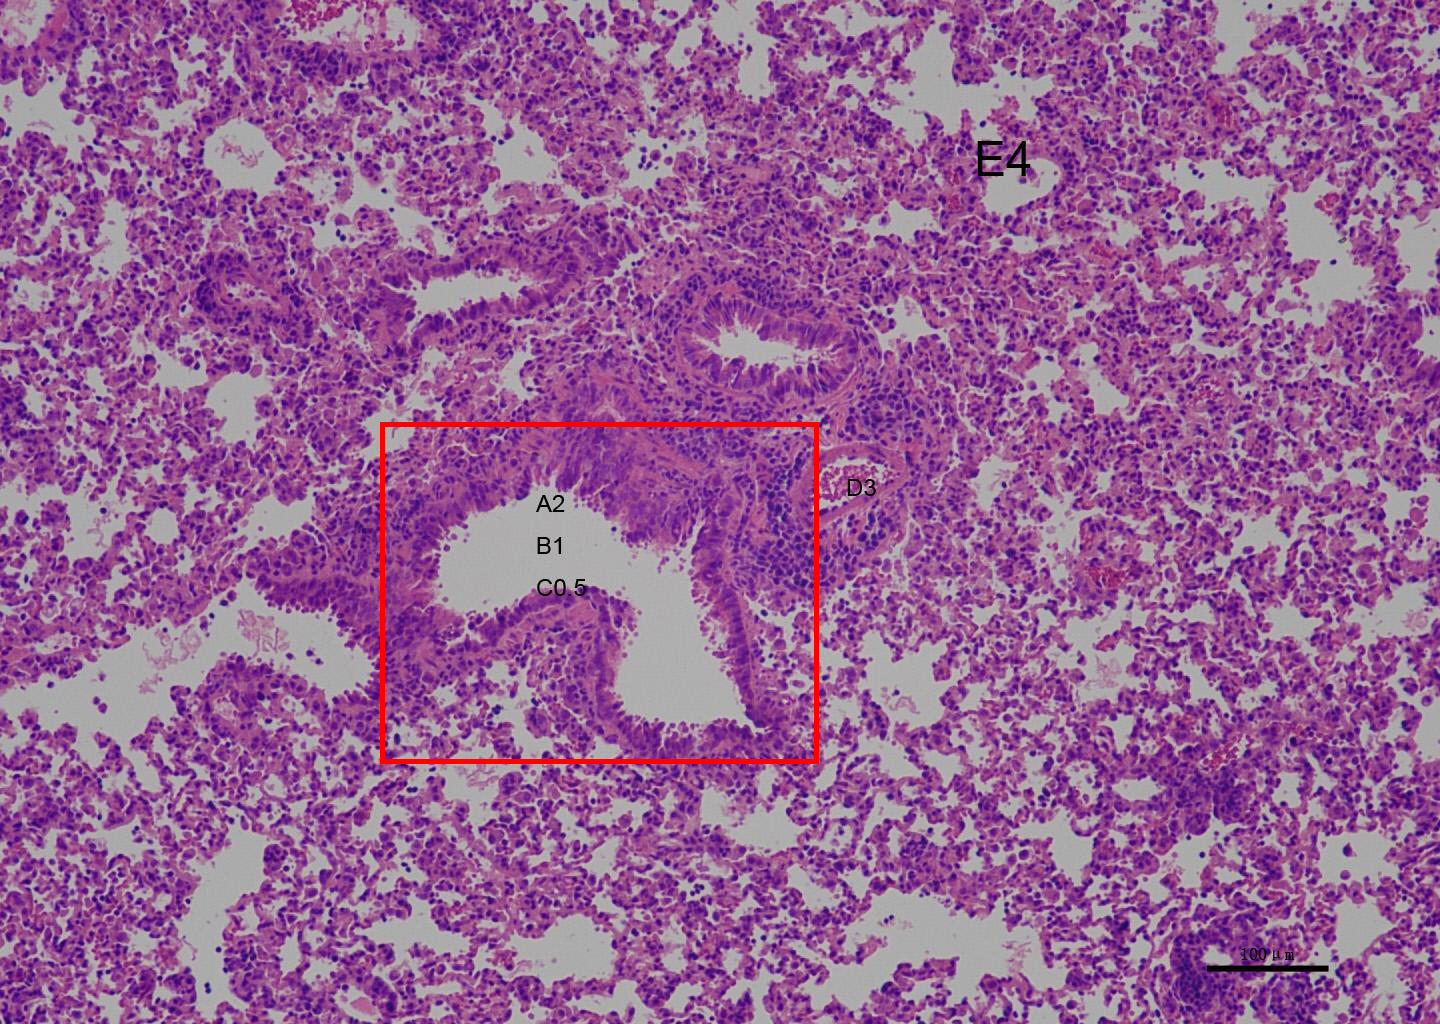

In [ ]:
from PIL import Image, ImageDraw, ImageFont

origin = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(origin)
draw.rectangle(xy=tuple(prediction[0]['boxes'][0]), fill=None, outline="red", width=5)
origin

In [ ]:
from torchvision.ops.boxes import nms

filtered_ids = nms(prediction[0]['boxes'], prediction[0]['scores'], 0.3)
filtered_ids

tensor([0, 3, 6, 7, 9], device='cuda:0')

In [ ]:
from torchvision import models
from torch.hub import load_state_dict_from_url
from torch import nn

class BoxRatingResNet18(models.ResNet):

  def __init__(self, pretrained=False, **kwargs):

    # Start with standard resnet18 defined here
    super().__init__(block = models.resnet.BasicBlock, layers = [2, 2, 2, 2], num_classes = num_classes, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(models.resnet.model_urls["resnet18"], progress=True)
        self.load_state_dict(state_dict)

    # Replace AdaptiveAvgPool2d with standard AvgPool2d
    self.avgpool = nn.AvgPool2d((7, 7))

    # Convert the original fc layer to a convolutional layer.  
    self.last_conv = torch.nn.Conv2d(in_channels = self.fc.in_features, out_channels = 1000, kernel_size = 1)
    self.last_conv.weight.data.copy_(self.fc.weight.data.view ( *self.fc.weight.data.shape, 1, 1))
    self.last_conv.bias.data.copy_(self.fc.bias.data)

    self.reg_layer = nn.Linear(1000, 1)

  # Reimplementing forward pass.
  def _forward_impl(self, x):
    # Standard forward for resnet18
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool(x)

    # Notice, there is no forward pass
    # through the original fully connected layer.
    # Instead, we forward pass through the last conv layer
    x = self.last_conv(x)
    x = self.reg_layer(x)
    return x

In [ ]:
import torch

class BoxRatingDataset(torch.utils.data.Dataset):
  def __init__(self, lb_labels, cls_name, transforms=None):
    self.transforms = transforms
    
    assert cls_name in SegClsName.get_all_names()
    self.cls_name = cls_name
    self.lb_labels = segmentation_cls_filter(lb_labels, cls_name)

  def __getitem__(self, idx):
    

  def __len__(self):
    return len(self.lb_labels)